In [24]:
"""
This is an example using CLAP to perform zeroshot
    classification on ESC50 (https://github.com/karolpiczak/ESC-50).
"""

from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os

In [84]:
# Load dataset
root_path = "/work/user_data/jtaylor/data/acoustic_scene_classification/data/CochlScene"
val_df = pd.read_csv(f'{root_path}/val_fold.tsv', sep='\t')
classes = val_df['scene_label'].unique()
display(val_df)

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'this is the sound of '
y = [prompt + x for x in classes]
print(y)

,filename,scene_label
0,Elevator/Elevator_user0433_14883771_002.wav,Elevator
1,Elevator/Elevator_user0670_14880726_003.wav,Elevator
2,Elevator/Elevator_user0334_15514929_004.wav,Elevator
3,Elevator/Elevator_user0817_15035480_000.wav,Elevator
4,Elevator/Elevator_user0698_15505461_002.wav,Elevator
...,...,...
7568,Kitchen/Kitchen_user0365_14829856_003.wav,Kitchen
7569,Kitchen/Kitchen_user0365_14829942_005.wav,Kitchen
7570,Kitchen/Kitchen_user0500_14825756_000.wav,Kitchen
7571,Kitchen/Kitchen_user0177_14857824_004.wav,Kitchen


{'Elevator': 0, 'Restaurant': 1, 'ResidentialArea': 2, 'Car': 3, 'SubwayStation': 4, 'Bus': 5, 'Cafe': 6, 'Park': 7, 'Street': 8, 'Restroom': 9, 'CrowdedIndoor': 10, 'Subway': 11, 'Kitchen': 12}
['this is the sound of Elevator', 'this is the sound of Restaurant', 'this is the sound of ResidentialArea', 'this is the sound of Car', 'this is the sound of SubwayStation', 'this is the sound of Bus', 'this is the sound of Cafe', 'this is the sound of Park', 'this is the sound of Street', 'this is the sound of Restroom', 'this is the sound of CrowdedIndoor', 'this is the sound of Subway', 'this is the sound of Kitchen']


In [85]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=False)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [86]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(val_df))):
    path, label = val_df.iloc[i]
    path = f'{root_path}/Val/{path}'
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 7573/7573 [14:25<00:00,  8.75it/s]  


In [87]:
y_labels, y_preds = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_labels, axis=1)
y_pred_val = np.argmax(y_preds, axis=1)
acc = accuracy_score(np.argmax(y_labels, axis=1), np.argmax(y_preds, axis=1))
print('ESC50 Accuracy {}'.format(acc))

ESC50 Accuracy 0.8502574937277169


In [88]:
print(y_label_val)
print(y_pred_val)

[ 0  0  0 ... 12 12 12]
[ 0  0  0 ... 12 12 12]


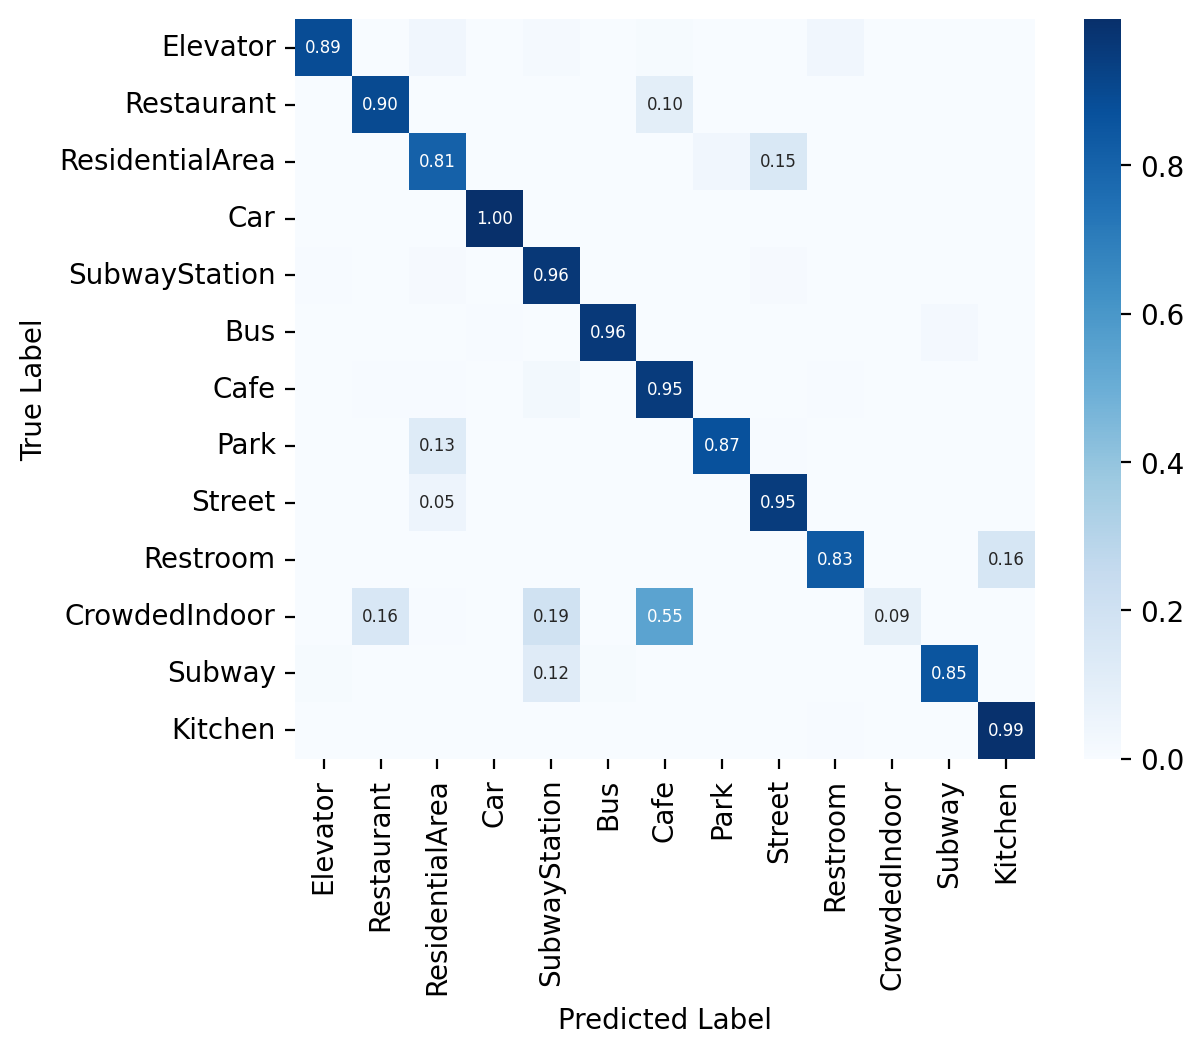

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()